In [1]:
!nvidia-smi

Fri Jun 30 09:24:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [4]:
%cd {HOME}

import sys
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

/content
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-nifatp3u
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-nifatp3u
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=142bd614da73ef5b1e5bee0f2d496fef227663b4cbe5cb2ef0311049ef4b546b
  Stored in directory: /tmp/pip-ephem-wheel-cache-gab_weg4/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [5]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.0 MB/s eta 0:00:00


In [6]:
%cd {HOME}
!mkdir {HOME}/weights
%cd {HOME}/weights

!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/content
/content/weights


In [7]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [8]:
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

In [9]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [10]:
mask_generator = SamAutomaticMaskGenerator(sam)

In [11]:
mask_predictor = SamPredictor(sam)

In [ ]:
import os


IMAGE_PATH = "/content/drive/MyDrive/NData/normal (174).jpg"


In [ ]:
# helper function that loads an image before adding it to the widget

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

In [ ]:
widget.bboxes

In [ ]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])

In [ ]:
import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

In [ ]:
box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red())

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

In [ ]:
import supervision as v

sv.plot_images_grid(
    images=masks,
    grid_size=(1, 4),
    size=(16, 4)
)

In [ ]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    # !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    IMAGE_PATH = "../NData/normal (174).jpg"

In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [12]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


In [ ]:
IMAGE_PATH = "/content/drive/MyDrive/NData/normal (1004).jpg"
image = cv2.imread(IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [15]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

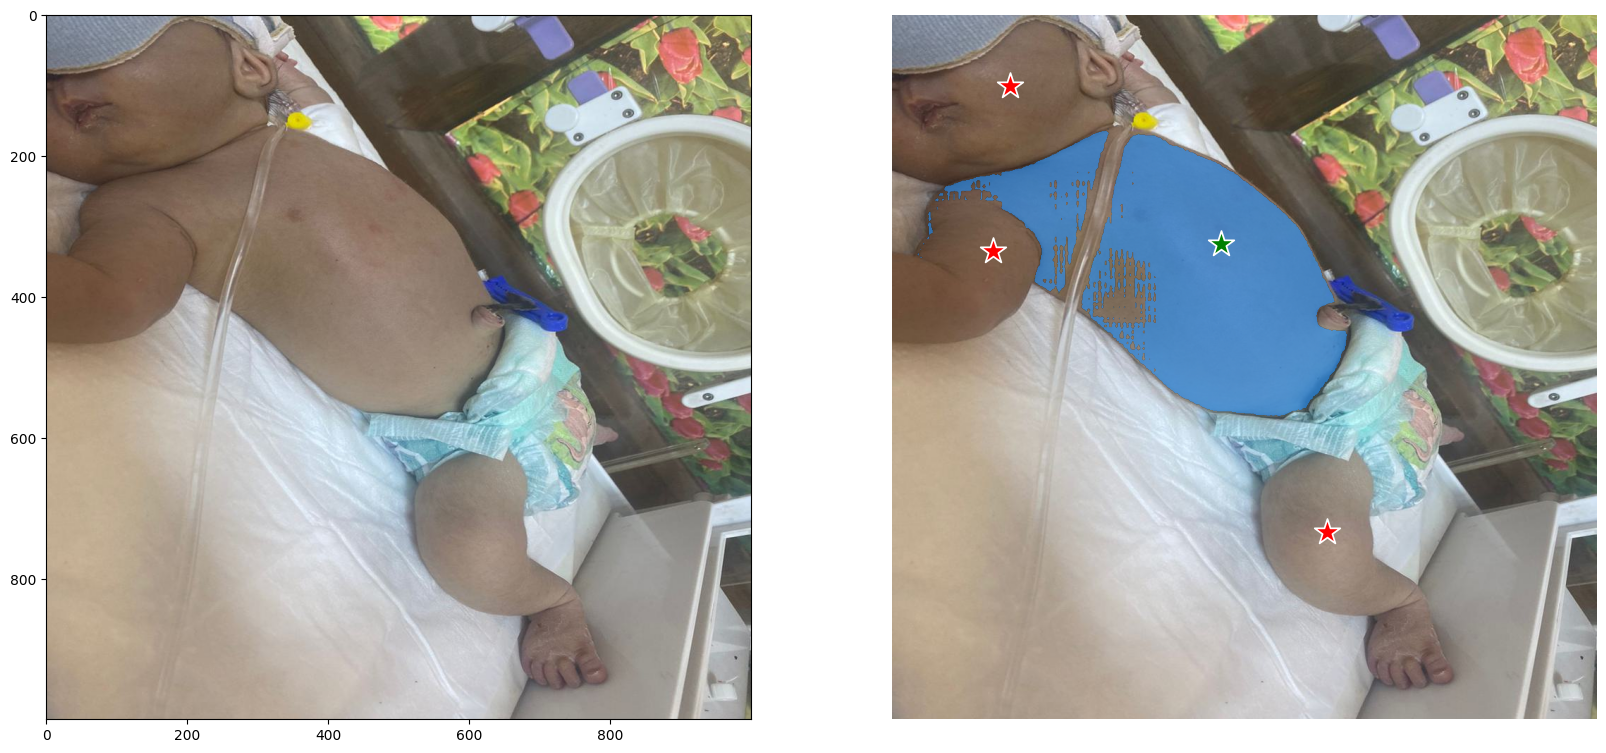

In [214]:
import numpy as np
img_id = 81
IMAGE_PATH = f"/content/drive/MyDrive/Project_NNJ/Project_NNJ/ANData/jaundice ({img_id}).jpg"
image = cv2.imread(IMAGE_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image)
input_point = np.array([[467, 325],[168, 101],[144, 335],[617, 734]])
# [353, 252],[527, 517],[609, 773],[164, 91],[53, 412]
# [1,1,0,0,0]81
input_label = np.array([1,0,0,0])
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(image)
plt.axis('on')
axs[1].imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()


In [203]:
import os
from PIL import Image
from google.colab import files

# create directory if it doesn't exist
if not os.path.exists('/content/drive/MyDrive/Project_NNJ/Project_NNJ//masked_Jaundice_png'):
    os.makedirs('/content/drive/MyDrive/Project_NNJ/Project_NNJ/masked_Jaundice_png')

if not os.path.exists('/content/drive/MyDrive/Project_NNJ/Project_NNJ//masked_Jaundice_npy'):
    os.makedirs('/content/drive/MyDrive/Project_NNJ/Project_NNJ/masked_Jaundice_npy')


# save masked images with custom name
img = Image.fromarray(masks[0])
img.save(f'/content/drive/MyDrive/Project_NNJ/Project_NNJ/masked_Jaundice_png/masked_Jaundice_{img_id}.png')

folder_path = '/content/drive/MyDrive/Project_NNJ/Project_NNJ/masked_Jaundice_npy'
file_name = f'masked_Jaundice_{img_id}.png.npy'
np.save(f'{folder_path}/{file_name}', img)


# download image
# files.download('../masked_normal/normal_mask_174.png.npy')

# move image to specified location
# !mv ../masked_normal/normal_mask_174.png ../Project_code/NNJ/Normal/masked_normal/


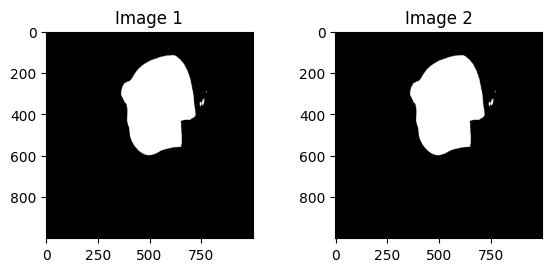

In [204]:

# Read the first image
image1 = cv2.imread(f'/content/drive/MyDrive/Project_NNJ/Project_NNJ/masked_Jaundice_png/masked_Jaundice_{img_id}.png')

# Read the second image
image2 = np.load(f'/content/drive/MyDrive/Project_NNJ/Project_NNJ/masked_Jaundice_npy/masked_Jaundice_{img_id}.png.npy')

# Check if images were loaded successfully
if image1 is not None and image2 is not None:
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2)

    # Display the first image on the left subplot
    axes[0].imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Image 1')

    # Display the second image on the right subplot
    axes[1].imshow(image2, cmap = 'gray')
    axes[1].set_title('Image 2')

    # Adjust the spacing between subplots
    plt.subplots_adjust(wspace=0.4)

    # Show the figure
    plt.show()
else:
    print('Failed to load one or both images.')


[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


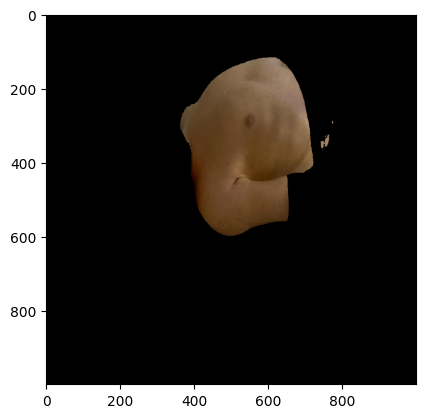

In [205]:

from matplotlib import pyplot as plt

if not os.path.exists('/content/drive/MyDrive/Project_NNJ/Project_NNJ//Segmented_Jaundice_images'):
    os.makedirs('/content/drive/MyDrive/Segmented_Jaundice_images')


# Load the original image
image = cv2.imread(f"/content/drive/MyDrive/Project_NNJ/Project_NNJ/ANData/jaundice ({img_id}).jpg")

# Load the mask from the PNG file
mask = np.load(f"/content/drive/MyDrive/Project_NNJ/Project_NNJ/masked_Jaundice_npy/masked_Jaundice_{img_id}.png.npy")
print(mask)
mask = mask.astype(np.uint8)
# Apply the mask to the image
masked_image = cv2.bitwise_and(image, image, mask=mask)

# Convert the masked image from BGR to RGB color space
masked_image1 = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
cv2.imwrite(f'/content/drive/MyDrive/Project_NNJ/Project_NNJ/Segmented_Jaundice_images/Segmented_Jaundice_image_{img_id}.png', masked_image)
# Show the masked image using matplotlib
plt.imshow(masked_image1)
plt.show()


In [206]:
import csv
image_name = f"Jaundice ({img_id})"
# File path to save the CSV data
csv_file_path = '/content/drive/MyDrive/Project_NNJ/Project_NNJ/coordinate_of_img.csv'

# Write the data to the CSV file
with open(csv_file_path, 'a', newline='') as file:
    writer = csv.writer(file)

    data = [image_name, str(input_point), str(input_label)]

    # Write the image data to a single row in the CSV file
    writer.writerow(data)
